# Fun with Fraud Detection

We will train an Autoencoder Neural Network (implemented in Keras) in unsupervised (or semi-supervised) fashion for Anomaly Detection in credit card transaction data. The trained model will be evaluated on pre-labeled and anonymized dataset.

First step: Loading required packages

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


## Loading the data

The dataset we’re going to use can be downloaded from Kaggle. It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven’t been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [3]:
df = pd.read_csv("./creditcard.csv")


In [4]:
df.shape

(284807, 31)

In [5]:
df.isnull().values.any()


False

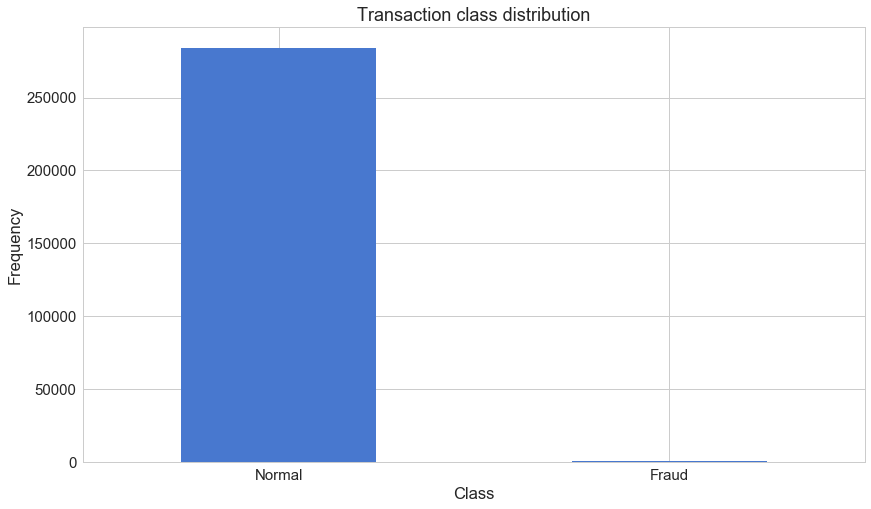

In [6]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [7]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [8]:
normal.shape

(284315, 31)

In [9]:
frauds.Amount.describe()


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

SyntaxError: invalid syntax (<ipython-input-10-15255790ace0>, line 1)

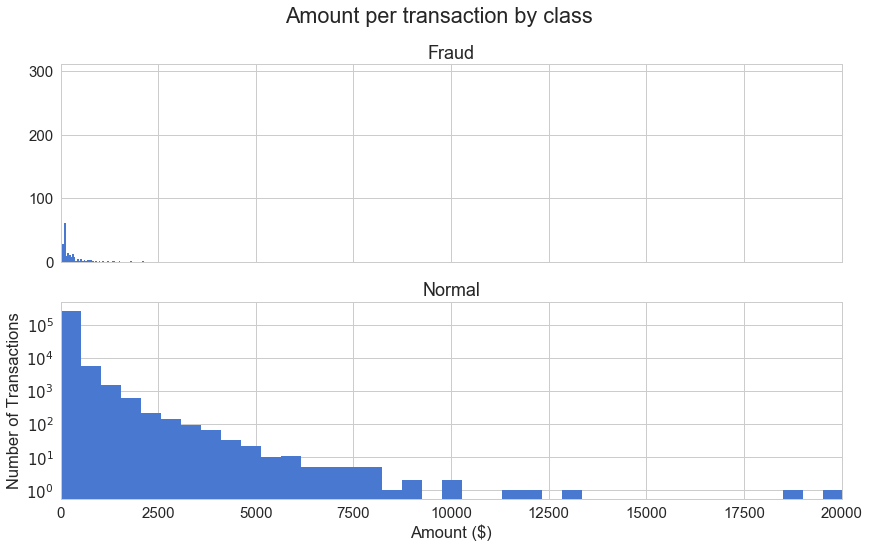

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

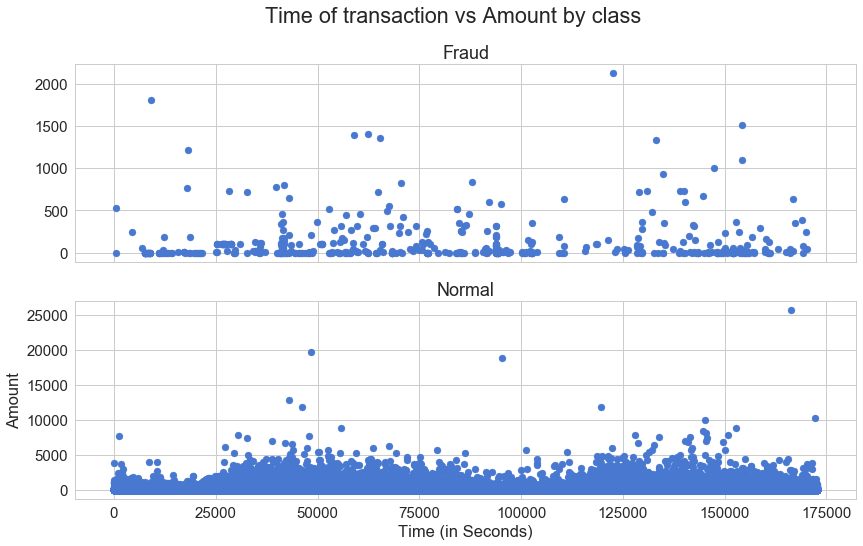

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [13]:
list(frauds)

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class']

In [14]:
frauds.V1.describe()


count    492.000000
mean      -4.771948
std        6.783687
min      -30.552380
25%       -6.036063
50%       -2.342497
75%       -0.419200
max        2.132386
Name: V1, dtype: float64

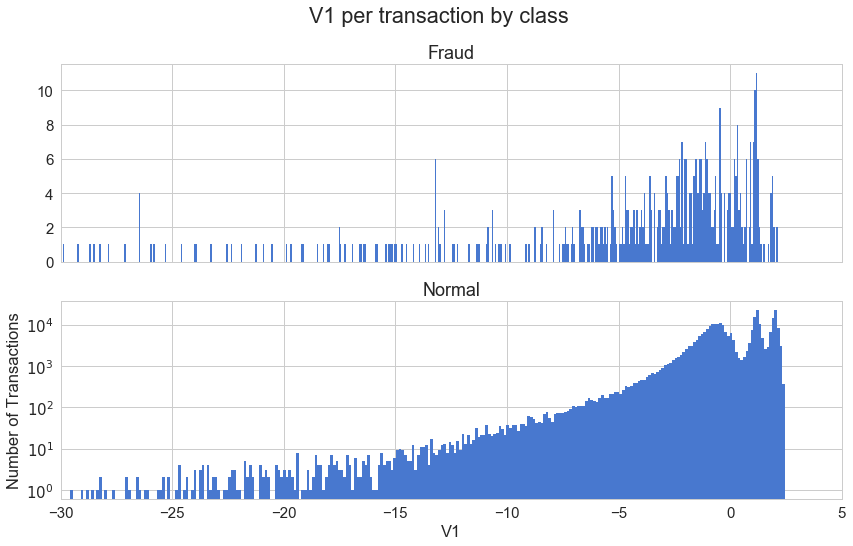

In [20]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('V1 per transaction by class')

bins = 500

ax1.hist(frauds.V1, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.V1, bins = bins)
ax2.set_title('Normal')

plt.xlabel('V1')
plt.ylabel('Number of Transactions')
plt.xlim((-30, 5))
plt.yscale('log')
plt.show();

In [21]:
frauds.dtypes


Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

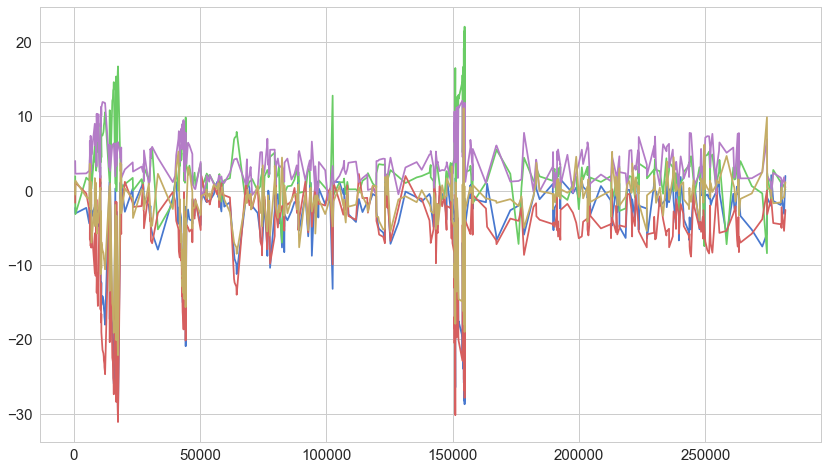

In [26]:
plt.plot(frauds.V1)
plt.plot(frauds.V2)
plt.plot(frauds.V3)
plt.plot(frauds.V4)
plt.plot(frauds.V5)



plt.show()

## Preparing the data

First, let’s drop the Time column (not going to use it) and use the scikit’s StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [27]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let’s say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:



In [49]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
print("Data Shape: "+str(data.shape))
print("Fraud Shape: "+str(frauds.shape))
print("DF Shape: "+str(df.shape))

print("Normal Shape: "+str(normal.shape))
print("X_train Shape: "+str(X_train.shape))
print("X_test Shape: "+str(X_test.shape))


Data Shape: (284807, 30)
Fraud Shape: (492, 31)
DF Shape: (284807, 31)
Normal Shape: (284315, 31)
X_train Shape: (227451, 29)
X_test Shape: (56962, 29)


## Building the model 
Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [31]:
input_dim = X_train.shape[1]
print()
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Let’s train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [ ]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 18s - loss: 0.8244 - acc: 0.5697 - val_loss: 0.7872 - val_acc: 0.6307

In [33]:
autoencoder = load_model('model.h5')


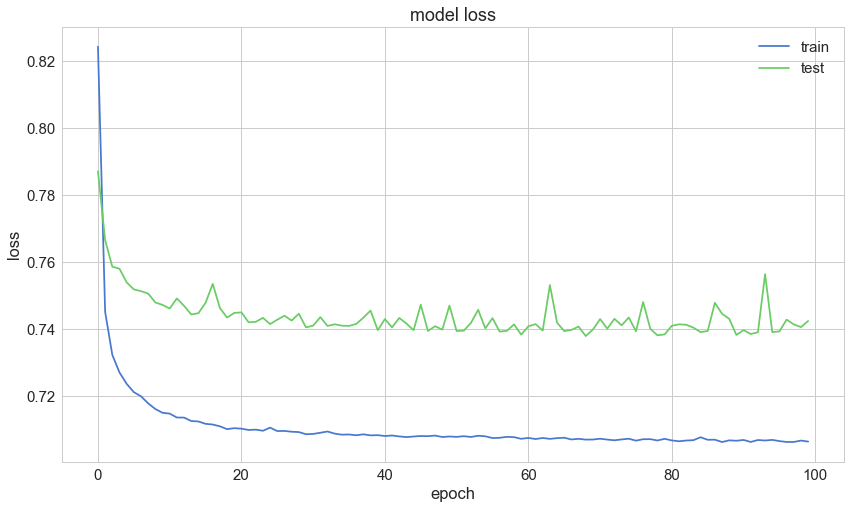

In [34]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [35]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.729558,0.001720
std,3.389695,0.041443
min,0.038524,0.000000
25%,0.241610,0.000000
50%,0.391679,0.000000
75%,0.619243,0.000000
max,259.080621,1.000000


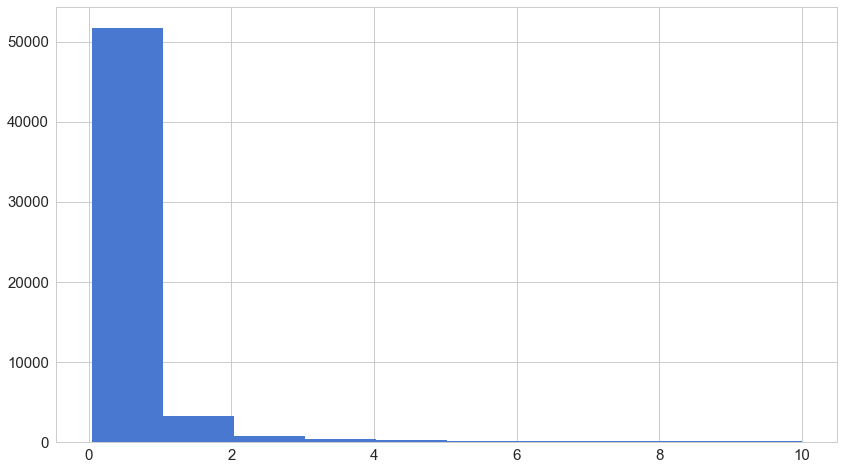

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

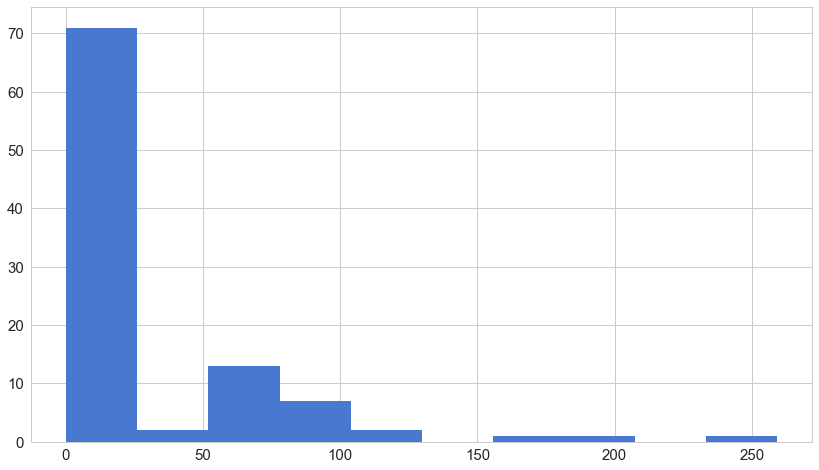

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [38]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)


ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let’s have a look at our ROC curve:

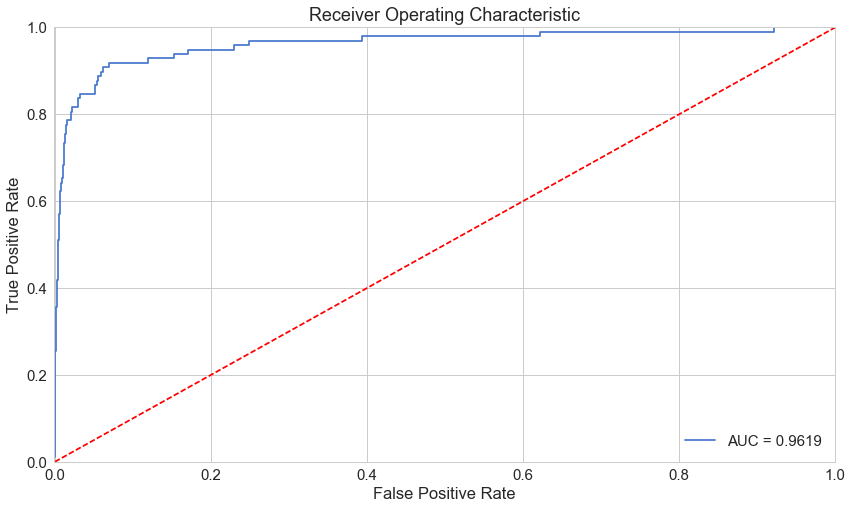

In [40]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Let’s take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let’s return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite — few returned results with very high relevancy. Ideally, you would want high precision and high recall — many results with that are highly relevant.

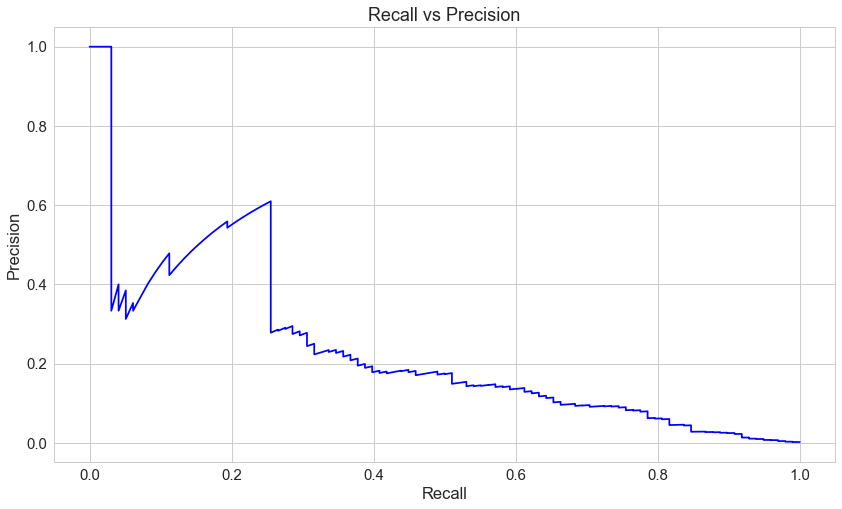

In [41]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

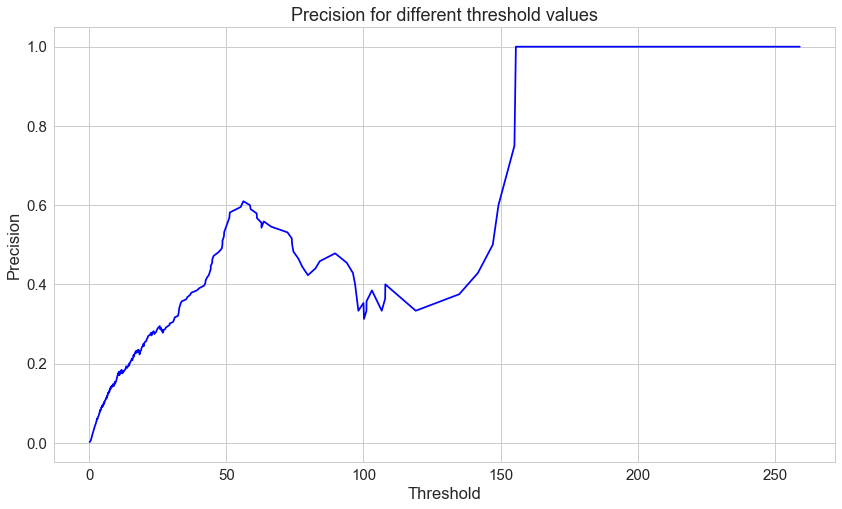

In [42]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let’s have a look at the recall:

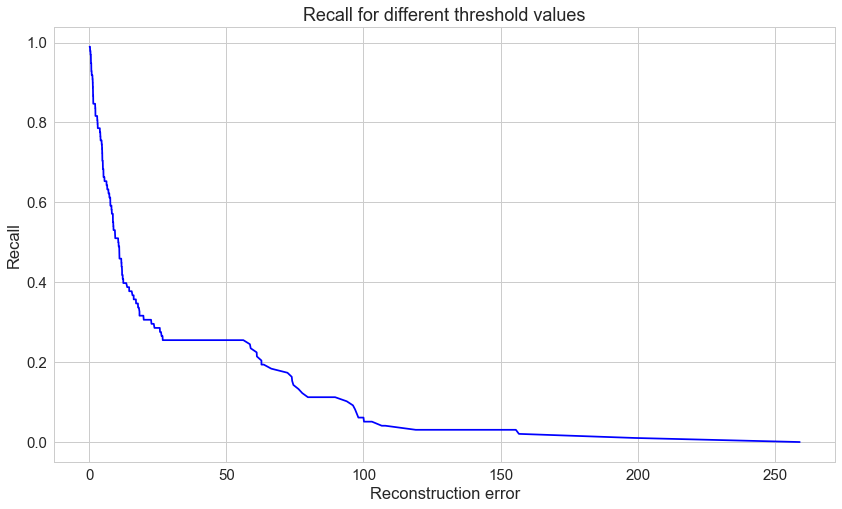

In [43]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

## Prediction
Our model is a bit different this time. It doesn’t know how to predict new values. But we don’t need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we’ll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we’ll mark it as a fraud (since our model should have a low error on normal transactions). Let’s pick that value:

In [44]:
threshold = 2.9

And see how well we’re dividing the two types of transactions:



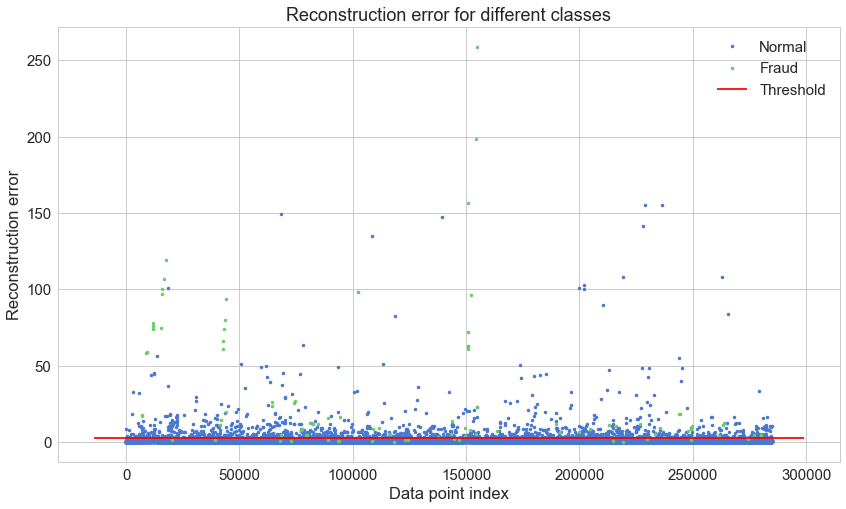

In [45]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let’s have a look at the confusion matrix:

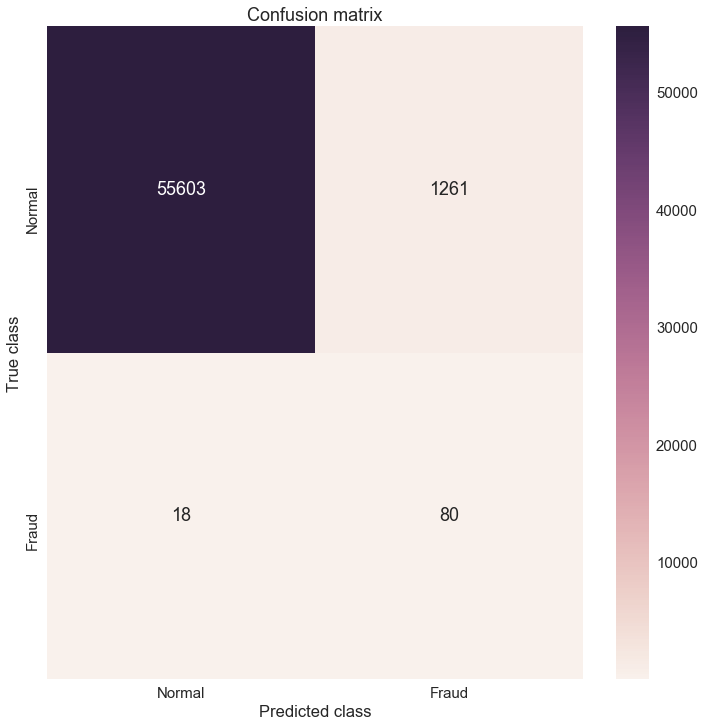

In [46]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). The number of normal transactions classified as frauds is really high. Is this really a problem? Probably it is. You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.

## Conclusion
We’ve created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn’t that cool? Our dataset was kind of magical, though. We really don’t know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one. Can you apply a similar model to a different problem?